### Objectif de la manip:
Mes données de mesures sont sur un espace borné, de dimension inférieure à ma simulation, pour cettee raison je dois compléter mes données expérimentales par un modèle à grande distance: d>5cm latéralement.

In [78]:
import numpy as np

In [79]:

# Charger le fichier CSV comme avant
data = np.loadtxt('mesureB_n.csv', delimiter=',', dtype=float)  # skiprows=1 pour ignorer l'en-tête si présent

#récupérer la ligne désirée en partant du bas
def fetchline(line_num):
    return np.flip(data[-line_num, :])
def fetchdist(offset=0.5):
    return np.arange(-5, 5.5, 0.5) - offset
line_num = 2
vals = fetchline(line_num)
offset = 0.
dist = fetchdist(offset)

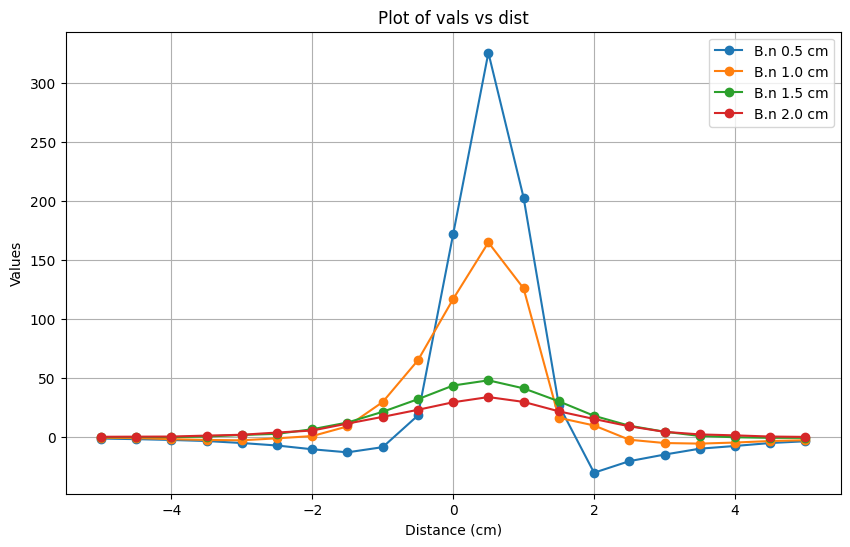

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
N=5
for i in range(1,N):
    plt.plot(dist, fetchline(i), marker='o', linestyle='-', label=f'B.n {i*0.5} cm')
plt.xlabel('Distance (cm)')
plt.ylabel('Values')
plt.title('Plot of vals vs dist')
plt.legend()
plt.grid(True)
plt.show()

comme il y a en théorie symétrie, je flip//a l'offset et je fais la moyenne des deux listes

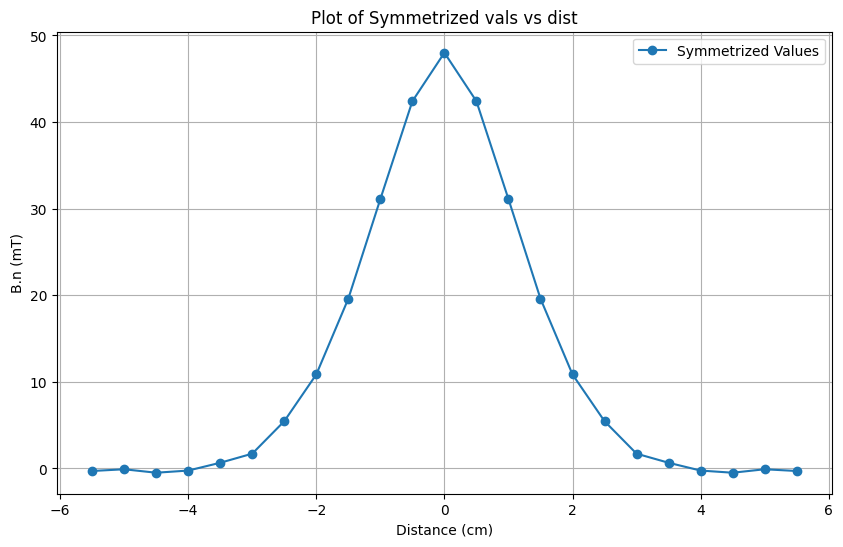

In [81]:
def moy_none(a,b):
    if a is None:
        return b
    if b is None:
        return a
    return (a+b)/2

def moy_sym(L:list, offset=0)->list:
    M = []
    n = len(L)
    for i in range(n+2*offset):
        index1 = i
        index2 = n+2*offset-i-1
        valeur1 = L[index1] if index1<n else None
        valeur2 = L[index2] if index2<n else None
        valeur = moy_none(valeur1, valeur2)
        M.append(valeur)
    return np.array(M)

def dist_sym(n,offset):
    return np.arange((-n//2-offset)*0.5+0.5, (n//2+offset)*0.5+0.5, 0.5)


vals_trunc = fetchline(3)
dist_trunc = dist_sym(len(vals_trunc),1)
vals_trunc = moy_sym(vals_trunc, offset=1)

plt.figure(figsize=(10, 6))
plt.plot(dist_trunc, vals_trunc, marker='o', linestyle='-', label='Symmetrized Values')
plt.xlabel('Distance (cm)')
plt.ylabel('B.n (mT)')
plt.title('Plot of Symmetrized vals vs dist')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
from scipy.interpolate import interp1d

def get_field_at_distance(distance, dist_array, vals_array):
    # Vérifie si la distance est dans les limites
    if distance < dist_array[0]:
        return vals_array[0]  # Valeur du bord gauche
    elif distance > dist_array[-1]:
        return vals_array[-1]  # Valeur du bord droit
    else:
        # Interpolation linéaire
        interpolator = interp1d(dist_array, vals_array, kind='linear', fill_value="extrapolate")
        return interpolator(distance)

# Exemple d'utilisation
distance_to_check = 2.75
field_value = get_field_at_distance(distance_to_check, dist_trunc, vals_trunc)
print(f"Valeur du champ à la distance {distance_to_check} : {field_value}")

Valeur du champ à la distance 2.75 : 3.575


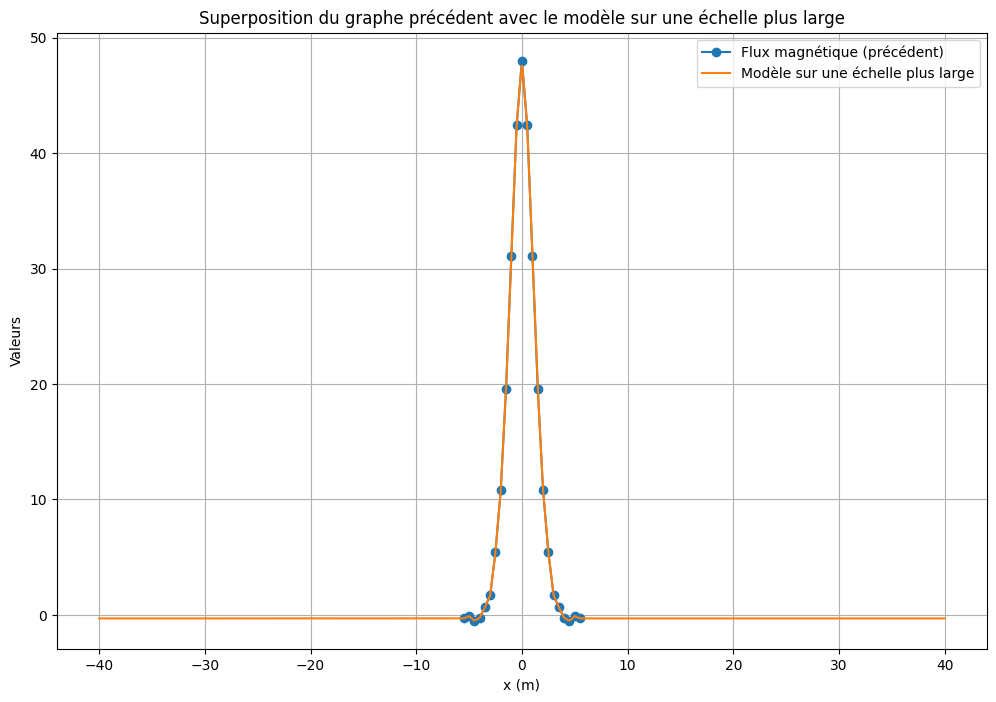

In [153]:
# Étendre la plage de x pour une échelle plus large
x_large = np.linspace(-40, 40, 1000)

# Calculer les valeurs du champ magnétique pour le modèle sur cette plage
field_values_large = [get_field_at_distance(x*1e-2, dist_trunc*1e-2, vals_trunc) for x in x_large]

# Superposer le graphe précédent avec le modèle
plt.figure(figsize=(12, 8))
plt.plot(dist_trunc, vals_trunc, label='Flux magnétique (précédent)', linestyle='-', marker='o')
plt.plot(x_large, field_values_large, label='Modèle sur une échelle plus large')
plt.xlabel('x (m)')
plt.ylabel('Valeurs')
plt.title('Superposition du graphe précédent avec le modèle sur une échelle plus large')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
BW=2e-2
BL=2e-2
#2x2cm selon les axes respectifs z et x

def get_flux(mag_funct, offsetx, deltax=0.5):
    #integration pas a pas
    # deltax est la taille de la cellule
    # mag_funct est une fonction qui prend en entrée la distance et renvoie la valeur du champ magnétique
    # on suppose B constant // à z, fonction de x
    # on intègre sur x et z
    flux = 0
    x_values = np.arange(-BW/2-offsetx, BW/2 - offsetx + deltax, deltax)
    for x in x_values:
        # On suppose que la fonction mag_funct est définie pour renvoyer le champ magnétique à une distance donnée
        B = mag_funct(x)  # On suppose que mag_funct est une fonction de x
        flux += B * deltax * BL  # Contribution de chaque cellule
        
    return flux

N_magnets = 5
mag_offset = 5e-2 #5cm max pour que le modele soit valide

def field_func(x):
    #somme les contributions de chaque aimant
    total_field = 0
    for i in range(N_magnets):
        # Position de l'aimant i
        magnet_position = -i * mag_offset
        # Contribution de l'aimant i
        total_field += ((-1)**i)*get_field_at_distance(x - magnet_position, dist_trunc*1e-2, vals_trunc)
    return total_field
#maintenant tracer le flux en fonction de deltax
N=1000
Tmax = 10  # 10 secondes
T = np.linspace(0, Tmax, N)  # Valeurs de deltax à tester
dt = Tmax/(N-1)
v = 0.5  # Vitesse de déplacement en m/s
x = -1  # Position initiale
flux_values = []
for t in T:
    flux = get_flux(field_func, x)
    flux_values.append(flux)
    deltax = v * dt
    x += deltax  # Mise à jour de la position

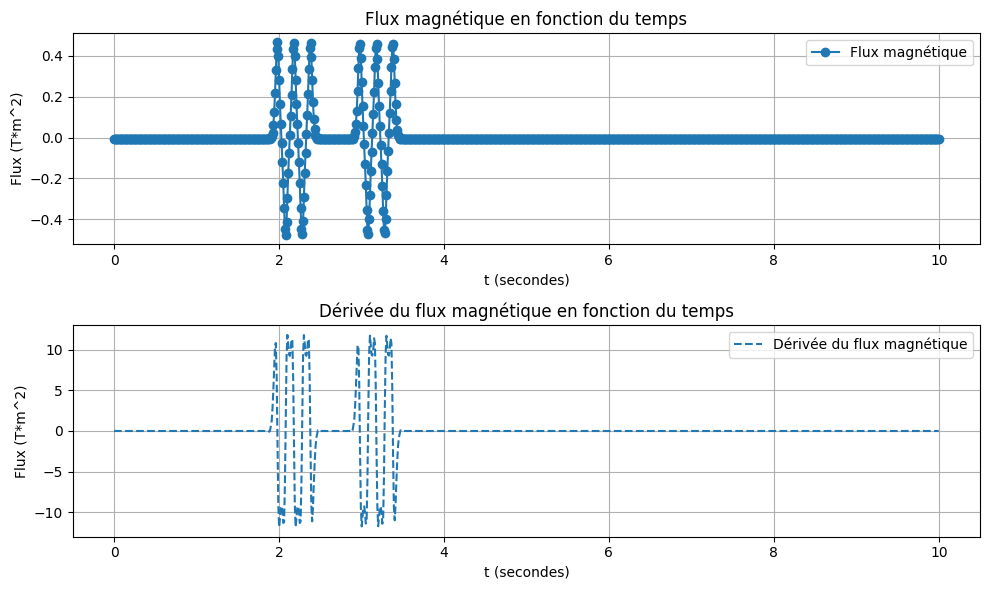

In [166]:
#plot flux en fonction de t
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(T, flux_values, marker='o', linestyle='-', label='Flux magnétique')
plt.xlabel('t (secondes)')
plt.ylabel('Flux (T*m^2)')
plt.title('Flux magnétique en fonction du temps')
plt.legend()
plt.grid(True)
#derivation
plt.subplot(2, 1, 2)
flux_derivative = np.gradient(flux_values, dt)
plt.plot(T, flux_derivative, marker='', linestyle='--', label='Dérivée du flux magnétique')
plt.xlabel('t (secondes)')
plt.ylabel('Flux (T*m^2)')
plt.title('Dérivée du flux magnétique en fonction du temps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

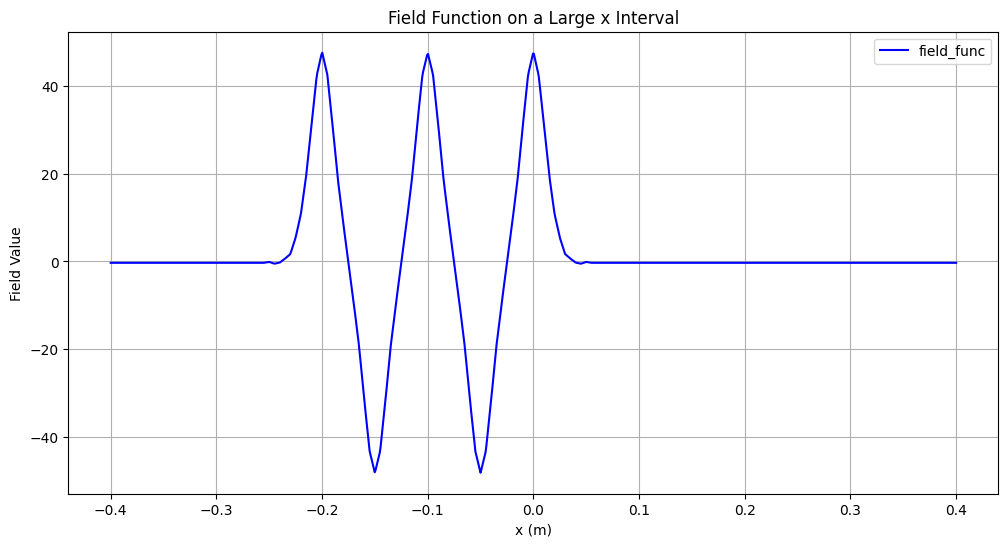

In [162]:
# Define a large x interval
x_interval = np.linspace(-40, 40, 1000)*1e-2

# Compute the field values for the interval
field_values = [field_func(x) for x in x_interval]

# Plot the field function
plt.figure(figsize=(12, 6))
plt.plot(x_interval, field_values, label='field_func', linestyle='-', color='blue')
plt.xlabel('x (m)')
plt.ylabel('Field Value')
plt.title('Field Function on a Large x Interval')
plt.legend()
plt.grid(True)
plt.show()